In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
#generate data
def true_f(x):
    return 1*np.cos(x)+1
xx=np.linspace(0,10,100)
x=np.linspace(0,10,15)
y=true_f(x)
dy=np.random.normal(0.25,0.05,len(y))
noise=np.random.normal(0,dy,len(y))
y+=noise

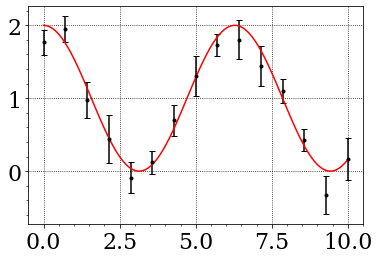

In [3]:
plt.errorbar(x=x,y=y,yerr=dy,fmt='.',label='generated noise')
plt.plot(xx,true_f(xx),label='true function')
noisy_data_dict={'x':x,'y':y,'dy':dy}
noisy_data=pd.DataFrame(data=noisy_data_dict)

In [224]:
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=pd.DataFrame(data=data)
        self.stan_data={'n':len(self.data['x'].values),
             'x':list(self.data['x'].values),
             'y':list(self.data['y'].values),
           'dy':list(self.data['dy'].values)}
        self.stanfile=stanfile
        self.x=self.data['x']
        self.y=self.data['y']
        self.dy=self.data['dy']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples)

    def f(self,x,a,b):
            return a*np.cos(x)+b
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['x'].values,self.data['y'].values,
                                   sigma=self.data['dy'].values)
            return popt,pcov
    def stan_code(self):
        return self.model.code()
    def samples_df(self):
        return self.fitobj.draws_pd()
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['x']))])
        lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['x']))])
        return lpd-pwaic, pwaic, lpd
    def plot_ppd(self,save,fitfunc,width=.5):
        samples=self.fitobj.draws_pd()
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
        ax.set_ylabel('$p(y_{rep}|y)$')
        ax.xaxis.set_ticks_position("top")
        ax.grid(which='minor',color='grey',lw='.4')
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['x']),np.max(self.data['x']),200)
        yfit=fitfunc(xx,*self.get_chisqpars(fitfunc)[0])
        ax.errorbar(x=self.data['x'],y=self.data['y'],yerr=self.data['dy'],fmt='.',label='Data points')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='r')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))],self.data['x'],showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            #b.set_color('red')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['x']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['y'][i]])/len(y_arr[i])for i in range(len(self.data['x']))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.plot(self.data['x'],pvalue,'.')
        ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
        ax1.set_xlabel('x')
        ax1.set_ylabel('$T(y_{rep}>y)$')
        ax1.set_ylim([0,1])
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        if (save==True):
            plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)
    def plot_posterior(self,params,func,save=False):
        samples=self.fitobj.draws_pd()
        chi2pars=self.get_chisqpars(function=func)
        fig, (ax)=plt.subplots(ncols=1,nrows=len(params),dpi=1000)
        print(len(params))
        for i in range(len(params)):
            ax[i].set_xlabel(params[i],fontsize=10)
            ax[i].set_ylabel('Frequency',fontsize=10)
            ax[i].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
            sns.kdeplot(samples[params[i]],ax=ax[i],color='black',linewidth=.5,bw=0.35,label='bayesian inference')
            kde_curve = ax.lines[0]
            x = kde_curve.get_xdata()
            y = kde_curve.get_ydata()
            maxpos = y.argmax()
            maxx=x[maxpos]
            ax[i].errorbar(x=chi2pars[0][i],y=0,xerr=chi2pars[1][i,i],label='$\chi^2$-fit',color='blue')
            
        plt.subplots_adjust(wspace=0.1,hspace=1.5)


            
    def plot_trace(self,params,save=False):
        samples=self.fitobj.draws_pd()
        fig, (ax)=plt.subplots(ncols=2,nrows=len(params),dpi=1000)
        #print(ax.shape)
        ls=['solid','dotted','dashed','dashdot']
        for i in range(len(params)):
            ax[i][0].grid(visible=False,axis='y')
            ax[i][0].set_xlabel(params[i],fontsize=10)
            ax[i][0].set_ylabel('Frequency',fontsize=10)
            ax[i][1].set_xlabel('iteration',fontsize=10)
            ax[i][1].set_ylabel(params[i],fontsize=10)
            for k in range(4):
                sns.kdeplot(samples[params[i]][k*1000:(k+1)*1000],ax=ax[i][0],
                    linestyle=ls[k],color='black',linewidth=.5,bw=0.35)
                ax[i][1].plot(np.arange(0,len(samples[params[i]])/4),
                    samples[params[i]][k*1000:(k+1)*1000],ls=ls[k],color='black',alpha=.7,linewidth=.5)
                for j in (0,1):
                    ax[i][j].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
                    #ax[i][j].set_title(params[i])
                    ax[i][j].tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(wspace=0.1,hspace=1.5)
        fig.set_size_inches(8.29,1*len(params))


            
            
        
        
  

        
        
        

In [225]:
fit=bayesian_fit(data=noisy_data_dict,stanfile='stan_file.stan')
fit1=bayesian_fit(data=noisy_data_dict,stanfile='stan_file1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/noisy_model/stan_file
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/noisy_model/stan_file1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [226]:
samples=fit.samples_df()
samples1=fit1.samples_df()

In [227]:
#fit.plot_ppd(save=False,fitfunc=fit.f,width=.75)
#fit1.plot_ppd(save=False,fitfunc=fit.f1,width=.75)

In [228]:
fit.waic()

(-258.3380415317837, 83.5957564934281, -174.74228503835562)

In [229]:
fit1.waic()

(-299.67106363093194, 138.57134727667957, -161.09971635425234)

2


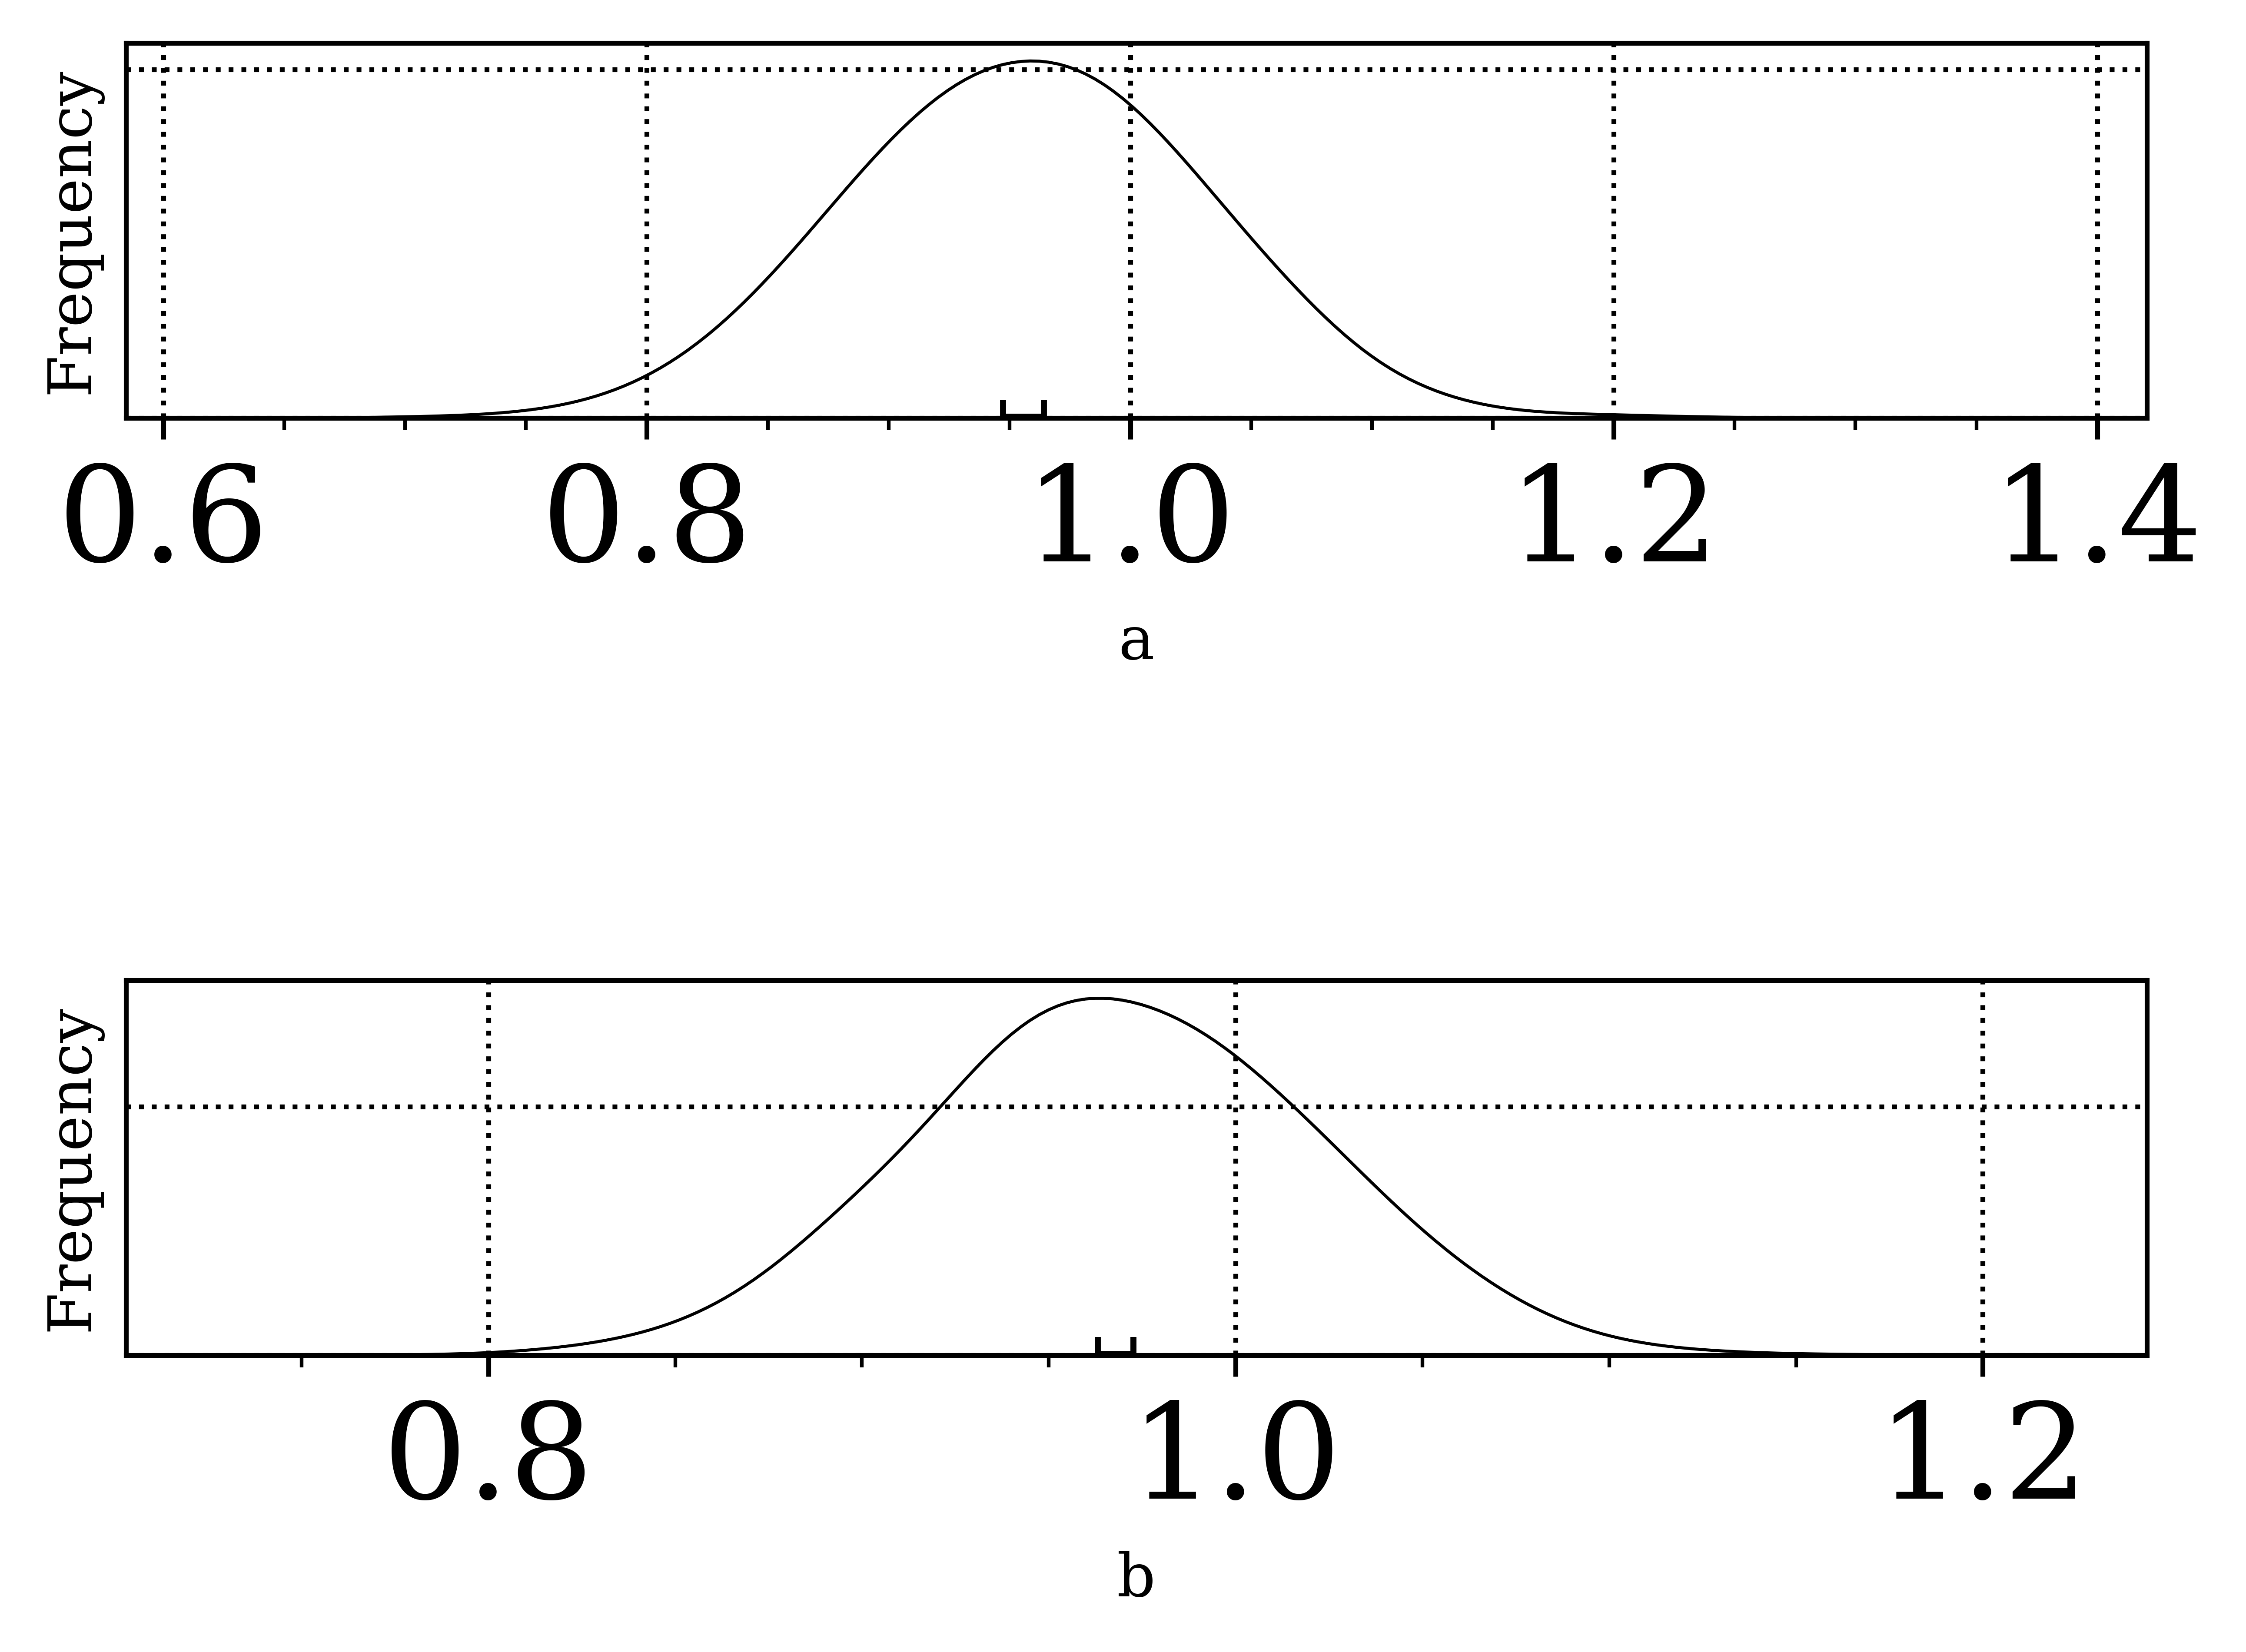

In [231]:
#fit1.plot_trace(params=['a','b','c'])
fit.plot_posterior(params=['a','b'],func=fit.f)
#fit.get_chisqpars(function=fit.f)